In [2]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats
import backtrader.indicators as btind
import quantstats as qs
import numpy as np

In [1]:
import sys

sys.path.append( '../../../utils' )
from data_manipulation import add_adj_close

In [28]:
min_data = pd.read_csv('../../../Data/Nifty/nifty_15min.csv')
daily_data = pd.read_csv('../nifty_daily_continous.csv')

In [29]:
adj = add_adj_close(min_data,daily_data)

In [30]:
adj.to_csv('nifty_15min_data.csv')

In [ ]:
class ORBStrategy(bt.Strategy):
    
    params = (
        ('atr_period', 20),
        ('stop_loss_factor', 3),
        ('take_profit_factor', 3),
        ('entry_size_pct', 0.1),
        ('exit_size_pct', 0.05),
    )

    def __init__(self):
        self.order = None
        self.stop_price = None
        self.take_profit = None
        self.atr = bt.indicators.ATR(period=self.params.atr_period)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.stop_price = self.buyprice - self.params.stop_loss_factor * self.atr[0]
                self.take_profit = self.buyprice + self.params.take_profit_factor * self.atr[0]
            else:
                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
        self.order = None

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data.high[0] > self.data.open[0] + self.atr[0] * 0.5:
                size = int(self.broker.getcash() * self.params.entry_size_pct)
                self.order = self.buy(size=size)
        else:
            if self.data.low[0] < self.stop_price or self.data.high[0] > self.take_profit:
                size = int(self.position.size * self.params.exit_size_pct)
                self.order = self.sell(size=size)
                
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(ORBStrategy)
    
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname='../nifty_15min_data.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Create an instance of an Analyzer subclass and add it to the Cerebro object
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    results = cerebro.run()
    strat = results[0]
    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)

    quantstats.reports.html(returns, output='stats.html', title='Nifty ORB')
    '''data = cerebro.plot()
    data[0][0].savefig("orb.png")'''

    pf.plotting.plot_rolling_returns(returns)
    cum_rets = qs.stats.compsum(returns)

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\amrit\AppData\Local\Progr

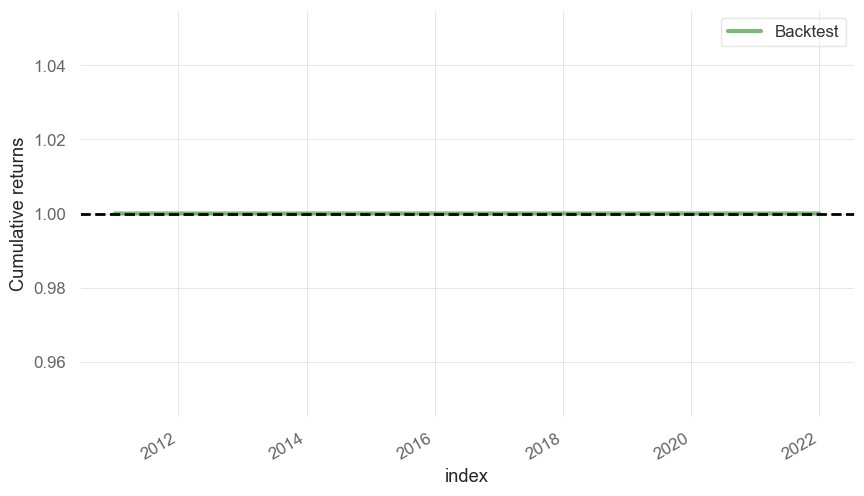

In [16]:
class OpenRangeBreakout(bt.Strategy):
    params = (
        ("atr_period", 20),
        ("stop_loss", 2),
        ("take_profit", 4),
    )

    def __init__(self):
        self.atr = bt.indicators.AverageTrueRange(self.data, period=self.params.atr_period)
        self.highest = bt.indicators.Highest(self.data.high, period=self.params.atr_period)
        self.lowest = bt.indicators.Lowest(self.data.low, period=self.params.atr_period)
        self.order = None

    def next(self):
        if not self.position:
            if self.data.high[0] > self.highest[0]:
                self.order = self.buy()
                self.sell(exectype=bt.Order.Stop, price=self.data.close[0] - self.atr[0] * self.params.stop_loss)
                self.sell(exectype=bt.Order.Limit, price=self.data.close[0] + self.atr[0] * self.params.take_profit)
        else:
            if self.data.low[0] < self.lowest[0]:
                self.order = self.sell()
            
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(OpenRangeBreakout)
    
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname='../nifty_15min_data.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Run over everything
    cerebro.run()

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    results = cerebro.run()
    strat = results[0]
    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    quantstats.reports.html(returns, output='stats.html', title='Nifty ORB')
    '''data = cerebro.plot()
    data[0][0].savefig("orb.png")'''

    pf.plotting.plot_rolling_returns(returns)